<h1 style="text-align: center; font-size: 500%; text-decoration: underline; font-weight: bold;">Concluding Assignment<h1>
<h2 style="text-align: center; font-size: 250%; font-weight: bold;">Ido Israeli (ID - 212432439)<br>Jonathan Derhy (ID - 315856377)<h2>
<h2 style="text-align: center; font-size: 400%; text-decoration: underline; font-weight: bold;">Part II<h2>

<h4 style="text-decoration: underline; font-weight: bold;">Imports<h4>

<h5 style="font-size: 95%">General Imports</h5>

In [1]:
import sys
# import string
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

<h5 style="font-size: 95%">Specific Imports</h5>

In [2]:
from typing import Union, Optional
from numpy.typing import ArrayLike
from functools import reduce
from matplotlib.gridspec import GridSpec
# from enum import Enum

<h5 style="font-size: 95%">Warnings Handling</h5>

In [3]:
import warnings
warnings.filterwarnings('ignore')

<h5 style="text-decoration: underline; font-weight: bold;">Functions for Debugging</h5>

In [4]:
#
def print_variable_data(variable, name=None):
    if not isinstance(name, str):
        name = "Unnamed Variable"
    print(f'-------------------{name}-------------------\n')
    print(f'Type: {type(variable)}')
    if isinstance(variable, np.ndarray): print(f'Shape: {variable.shape}')
    elif isinstance(variable, list): print(f'Shape: {len(variable)}')
    print(f'contents:\n{variable}')
    print("\n--------------------------------------\n")

#
def delete_global_var(var_name: str,
                      notify_done: bool=False,
                      notify_missing: bool=False,
                      throw: bool=False) -> None:
    if not isinstance(var_name, str):
        if throw:
            raise TypeError("Argument 'var_name' must be of type 'str'")
        else: return
    try:
        globals().pop(var_name)
    except KeyError:
        if notify_missing:
            print(f'There is no variable named "{var_name}".')
        if throw:
            raise KeyError(f'There is no variable named "{var_name}".') from None
        return
    if notify_done: print(f'Deleted "{var_name}".')


In [5]:
from typing import Union

class TypeValidator:

    @staticmethod
    def __format_error(error_msg:str):
        max_line_len: int = max([len(line) for line in str.splitlines(error_msg)]) + 2
        dashed_line = "\n" + "-"*max_line_len + "\n"
        return f'{dashed_line}{error_msg}.{dashed_line}'

    @staticmethod
    def __format_not_of_type_error_message(type_:type, variable_name:Union[str,None]=None):
        if not isinstance(type_, (tuple, type)):
            raise ValueError(TypeValidator.__format_error(f'"{type_}" is not a valid type'))
        name = ""
        if isinstance(type_, tuple):
            if not type_:
                raise ValueError(TypeValidator.__format_error("no types provided"))
            for idx, t in enumerate(type_):
                if not isinstance(t, type):
                    raise ValueError(TypeValidator.__format_error(f'"{t}" is not a valid type'))
                if idx > 0:
                    name += ", nor of the type "
                name += "'" + t.__name__ + "'"     
        else:
            name += "'" + type_.__name__ + "'"
                  
        str = "\"" + variable_name + "\" " if variable_name is not None else ""
        return TypeValidator.__format_error(f'Variable {str}is not of the type {name}')

    @staticmethod
    def __print_not_of_type_error_message_and_exit(types_: type, variable_name:Union[str,None]=None):
        try:
            type_err_msg = TypeValidator.__format_not_of_type_error_message(types_, variable_name)
        except ValueError as val_err_msg:
            raise ValueError(val_err_msg)
        raise TypeError(type_err_msg)

    @staticmethod
    def __get_types_tuple(types_):
        if isinstance(types_, tuple):
            return types_
        if isinstance(types_, (list, np.ndarray)):
            if isinstance(types_, np.ndarray) and not types_.ndim:
                types_ = [types_.tolist()]
            return tuple(types_)
        return (types_,)

    @staticmethod
    def __check_if_not_of_types_and_handle(variable, types_, variable_name:Union[str,None]=None):
        types_tup = TypeValidator.__get_types_tuple(types_)
        is_types_invalid = True
        try:
            if not isinstance(variable, types_tup):
                is_types_invalid = False
                TypeValidator.__print_not_of_type_error_message_and_exit(types_tup, variable_name)
        except TypeError:
            if is_types_invalid:
                raise ValueError(TypeValidator.__format_error(f'"{types_}" is/contains an invalid type'))
            raise

    @staticmethod
    def validate_variables_types(variable_list, types, variable_names_list: Union[list,str,None]=None):
        if not isinstance(variable_list, (list, tuple, np.ndarray)):
            variable_list = [variable_list]
        if not isinstance(types, (list, tuple, np.ndarray)):
            types = [types]
        if variable_names_list is None:
            variable_names_list = []
        elif isinstance(variable_names_list, str):
            variable_names_list = [variable_names_list]
        if len(variable_names_list) < len(variable_list):
            variable_names_list += [None]

        if len(variable_list) == 1:
            types = np.array(types).flatten()
            TypeValidator.__check_if_not_of_types_and_handle(variable_list[0], types, variable_names_list[0])
            return

        types_len: int = len(types)-1
        names_len: int = len(variable_names_list)-1
        types_idx = names_idx = 0
        for var in variable_list:
            TypeValidator.__check_if_not_of_types_and_handle(var, types[types_idx], variable_names_list[names_idx])
            if types_idx < types_len:
                types_idx+=1
            if names_idx < names_len:
                names_idx+=1

<style>
    * {
        font-size: small;
    }

    .ExampleDiv {
        display: grid;
        grid-template-columns: min-content auto;
        grid-column-gap: 1vw;
    }

    .ExampleTitle {
        text-decoration: underline;
    }

    .ExampleBody {
        display: inline-block;
    }

    /* span {
        display: inline-block;
    } */

    li {
        /* list-style-type: circle; */
    }
</style>

Remember that if you are passing a variable which is an iterable (`list`, `tuple`, or `numpy.ndarray`) for type validation, the `TypeValidator` would<br> 
take it as if it is an iterable of variables, each needs validation:
<ul>
    <li>
        <div class="ExampleDiv">
            <span class="ExampleTitle">Example:</span>
            <span class="ExampleBody">
If you have an iterable variable :

    ```python
        x = [1, 2, 3]
    ```
and you try passing it like so :

    ```python
        TypeValidator.validate_variables_types(x, (str, list), "x")
    ```
The `TypeValidator` will actually check if `x[0]` is of type str, and if `x[1]` and `x[2]` are of type list.
            </span>
        </div>
    </li>
</ul>

To avoid that - make sure you encapsulate an iterable variable within an iterable:
<ul>
    <li>
        <div class="ExampleDiv">
            <span class="ExampleTitle">Example:</span>
            <span class="ExampleBody">
If you have an iterable variable :

    ```python
        x = [1, 2, 3]
    ```
try passing it encapsulated within a list (or tuple or np.ndarray), like so :

    ```python
        TypeValidator.validate_variables_types([x], (str, list), "x")
    ```
This would work.
            </span>
        </div>
    </li>
</ul>

```python
TypeValidator.validate_variables_types([x], (str, list), "x")
```

---

<h3 style="text-decoration: underline; font-weight: bold;">Part A: Preparing the data to train a linear classifier<h3>

<h4 style=" font-weight: bold;">Functions for Selecting Train and Test Data</h4>

In [6]:
#
def shuffle_dataframe(df):
    TypeValidator.validate_variables_types(df, pd.DataFrame, "df")
    return df.sample(frac=1)

#
def select_train_and_test_by_train_percentage(df, train_percentage, toShuffle=False):
    TypeValidator.validate_variables_types(df, pd.DataFrame, "df")
    if toShuffle:
        train = df.sample(frac=train_percentage)
        test = df.drop(train.index)
    elif not toShuffle:
        num_of_train_entries = (int)(df.shape[0] * train_percentage)
        train = df.head(num_of_train_entries)
        test = df.tail(df.shape[0] - num_of_train_entries)
    return train, test

<h4 style=" font-weight: bold;">Functions for Data Format Manipulation</h4>

In [7]:
#
def get_dictionary_from_1darray(keys):
    dictio = {}
    dictio.update({key:0 for key in keys})
    return dictio

#
def get_ndarray_from_dataframe(df):
    TypeValidator.validate_variables_types([df], pd.DataFrame, "df")
    # return df[df.columns[:]].values
    return np.array(df)

#
def extract_entries_with_specified_values_in_columns(df: pd.DataFrame,
                                                     columns: Union[str, tuple[str], list[str], np.ndarray],
                                                     values) -> pd.DataFrame:
    """
    Extracts the entries that have the specified values in the specified columns.
    
    :return: A pd.DataFrame consisting of only the entries that have the specified values in the specified columns.
    """
    if isinstance(columns, str): # if true - only a single column
        if not hasattr(values, '__iter__'): # if true - values is *not* a non-string iterable (e.g. list, tuple, np.ndarray)
            values = [values]
        return df.loc[df[columns].isin(values)]
    return df.loc[reduce(lambda x, y: x & y, [df[col] == val for col, val in zip(columns, values)])]

#
def extract_desired_features(df, features_list, disregard_capitalization=True):
    TypeValidator.validate_variables_types([df, features_list], [pd.DataFrame, (list, tuple, np.ndarray)], ["df", "features_list"])

    if disregard_capitalization:
        features_list: list = [s.lower() for s in features_list if isinstance(s, str)]
    matching_columns: list = [col for col in df.columns if (col.lower() if disregard_capitalization else col) in features_list]
    
    return df[matching_columns]

#
def separate_features_and_classifications(entries, classifications_column: Optional[str]=None):
    """
    Separates the features of all the entries in a table from their respective classification.
    Assumes that the classification is found at the last index of every row.

    :param entries: A numpy.ndarray or a pandas.DataFrame that holds entries with both features and classifications.

    :return: A tuple of the features at index 0 and the classifications at index 1.
    
    :error: throws a TypeError if argument entries is not an instance of either numpy.ndarray or pandas.DataFrame
    """
    TypeValidator.validate_variables_types([entries], (pd.DataFrame, np.ndarray), "entries")

    if isinstance(entries, pd.DataFrame):
        if (classifications_column is not None) & (classifications_column in entries.columns):
            classifications = entries[classifications_column].values
            features = entries.drop(classifications_column, axis=1).values
        else:
            features = entries[entries.columns[:-1]].values
            classifications = entries[entries.columns[-1]].values
    else:
        features = entries[:, :-1]
        classifications = entries[:, -1]
        
    return features, classifications


<h4 style=" font-weight: bold;">Functions for Graphing Data</h4>

In [8]:
#
def add_pie_chart(ax: plt.Axes,
                  values: pd.Series,
                  labels: Union[list, None]=None,
                  explode: Union[ArrayLike, None]=None,
                  colors: Union[ArrayLike, None]=None,
                  autopct: Union[str, None]=None,
                  wedges_width: float=1,
                  shadow: bool=False,
                  textfont: Union[int, None]=None) -> None:
    """
    Adds a pie chart to an axis given as argument.

    :param ax: The axis to which a pie chart will be added.

    :param values: The values of the chart.

    :param labels: The labels for the chart. If labels is None than the default labels will be taken.
                    In order to have no labels make labels an empty list (labels=[ ]).
    """
    ax.pie(
        values,
        labels= values.index if labels is None else labels if labels else None,
        explode= explode,
        autopct= autopct,
        colors= colors,
        shadow= shadow,
        wedgeprops= dict(width=wedges_width),
        textprops= None if textfont is None else dict(fontsize=textfont))
    
#
def colors_match_labels(label_color_dict: dict, labels: ArrayLike) -> list:
    return [label_color_dict[f'{label}'] for label in labels]

<h4 style="text-decoration: underline; font-weight: bold;">Data Extraction</h4>

In [9]:
df = pd.read_csv('./Resources/Data/data.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


<h4 style="text-decoration: underline; font-weight: bold;">Dividing the Data into Train and Test</h4>

In [10]:
number_of_all_entries: int = len(df.index)
train_percentage: float = 0.8
number_of_train_entries: int = round(train_percentage * number_of_all_entries)
number_of_test_entries: int = round((1 - train_percentage) * number_of_all_entries)

print(
    f'There are a total of {number_of_all_entries} entries.\n' +
    f'With the percentage of the train data being {train_percentage:.0%} of the total number of entries:\n' +
    f'There are a total of {number_of_train_entries} train entries\n' +
    f'and a total of {number_of_test_entries} test entries.\n' +
    f'\n({number_of_train_entries} + {number_of_test_entries} = {number_of_train_entries + number_of_test_entries})'
    )

There are a total of 8693 entries.
With the percentage of the train data being 80% of the total number of entries:
There are a total of 6954 train entries
and a total of 1739 test entries.

(6954 + 1739 = 8693)


In [11]:
D_train, D_test = select_train_and_test_by_train_percentage(df, train_percentage)

In [12]:
D_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,7376_01,Europa,True,E/477/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Neutrin Mirinanty,True
6950,7377_01,Earth,True,G/1186/P,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Estine Steelerettt,False
6951,7379_01,Earth,False,F/1416/S,TRAPPIST-1e,20.0,False,9.0,0.0,1540.0,0.0,0.0,Annard Bryants,False
6952,7385_01,Earth,False,F/1417/S,PSO J318.5-22,19.0,False,40.0,0.0,77.0,572.0,0.0,Coracy Reyerson,False


In [13]:
D_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6954,7388_01,Earth,True,G/1198/S,PSO J318.5-22,17.0,False,0.0,0.0,0.0,0.0,0.0,Sterry Mclardson,True
6955,7390_01,Earth,False,G/1190/P,TRAPPIST-1e,62.0,False,240.0,0.0,0.0,586.0,10.0,Isa Wiggs,False
6956,7391_01,Earth,True,G/1191/P,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,NaN,0.0,Joycey Coffmaney,False
6957,7392_01,Earth,True,G/1192/P,TRAPPIST-1e,37.0,False,0.0,0.0,0.0,0.0,0.0,Floyde Holton,False
6958,7393_01,Earth,False,E/478/P,NaN,40.0,False,0.0,0.0,0.0,7.0,782.0,Coracy Barks,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


We chose to have 80% of the data comprise our train dataset and have the remaining 20% comprise the test dataset.<br>
This is because, when attempting to classify data, a large enough training dataset is required so that<br>
we get a good distribution of features and classifications.<br>
We don't want to have a dataset in which all entries have the same classification, because that will make it so that<br>
when we try to classify an entry that should be classified as the opposite class, there would not be any neighbor to indicate that.<br>
Because all possible neighbors wouldn't be of that classification, there is no neighbor that would gravitate the result into being the correct one.<br>
<br>
A ratio of 80-20 or even 70-30 serves us well, because we are able to have a large enough training dataset while also having a sufficient amount of entries left for testing.<br>

<h4 style="text-decoration: underline; font-weight: bold;">Understanding the Raw Data</h4>

Before we pick and choose which attributes and features will be used to determine the classification,<br>
let's have a look at the data in a more indicative way<br>
<br>
We'll start by checking the very basics of the data - the columns, how many are there of each and their types:

In [14]:
print("\t\t---Info---")
df.info()

		---Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


As shown, the Dataframe includes 8693 entries and 14 columns.<br>
There are 6 columns that are of the type `float64`, 7 of the type `object`, and 1 of type `bool`.<br>
We will refer to the 'float64' columns as "Numerical Features" or "Numerical Attributes",<br>
and we will refer to the 'object' columns as "Categorical Features" or "Categorical Attributes".<br>
The 'bool' column is the "Transported" column, which is the classification for the entry.<br>
<br>
An important thing to notice is that even though there are 8693 entries in the Dataframe, some columns have less than 8693 non-null entries.<br>
This means that those columns have some vacant cells.<br>
<br>
Let's see how many of those are in each column:

In [15]:
#
def how_many_NaN_in_each_column(df):
    return df.isnull().sum()

#
def print_how_many_NaNs(df):
    how_many_each = how_many_NaN_in_each_column(df)
    if not how_many_each.any():
        print("There are no more NaN values in the Dataframe.")
    else:
        print("How many values are missing in each column:")
        print(how_many_each)

In [16]:
missing_per_column_df = how_many_NaN_in_each_column(df)
print("How many are missing in each column:")
missing_per_column_df

How many are missing in each column:


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Let's also display the amount of missing values as a percentage of the total

In [17]:
print("Percentage of missing values in each column:")
missing_per_column_df_percentage = (missing_per_column_df/len(df.index)).apply(lambda val: f'{val:.0%}' if not val else f'{val:.3%}')
missing_per_column_df_percentage

Percentage of missing values in each column:


PassengerId         0%
HomePlanet      2.312%
CryoSleep       2.496%
Cabin           2.289%
Destination     2.094%
Age             2.059%
VIP             2.335%
RoomService     2.082%
FoodCourt       2.105%
ShoppingMall    2.393%
Spa             2.105%
VRDeck          2.163%
Name            2.301%
Transported         0%
dtype: object

We will need to account for those missing values later down the line. The most logical thing is to attempt to fill them by guessing.<br>
But guessing is a dangerous game that may affect our results, so we need to do it cautiously.<br>
There are three methods that we may utilize in order to fill the blanks:

<style>
    .grid {
        display: grid;
        grid-template-columns: max-content auto;
        grid-column-gap: 1vw;
    }

    .underlined {
        text-decoration: underline;
    }

    ol, ul {
        margin-left: 2vw;
    }
</style>
<sub>
<ol>
    <li>
        <div class="grid">
            <span class="underlined">Most Common:</span>
            <span>
                We fill the blanks with the value that is the most common in that particular column <b>amongst all the entries in the Dataframe</b>.
            </span>
        </div>
    </li>
    <br>
    <li>
        <div class="grid">
            <span class="underlined">Mean:</span>
            <span>
                We fill the blanks with the average value of the particular column. This can be used only when the values can be quantified and averaged.
            </span>
        </div>
    </li>
    <br>
    <li>
        <div class="grid">
            <span class="underlined">KNN Based:</span>
            <span>
                We fill a blank cell with the value that is the most common <b>amongst the k nearest neighbors</b>.<br>
                There are main two variations to this:
                <ul>
                    <li>
                        k nearest index-wise entries in the Dataframe
                    </li>
                    <li>
                        k nearest entries according to other columns that are probably related or at least indicative of the column with the missing value.
                    </li>
                </ul>
            </span>
        </div>
    </li>
<ol>
</sub>

Now let's take a look at how many unique values are in each column:

In [18]:
df.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

While some columns are bound to have a lot of unique values because of what the represent (e.g. RoomService, FoodCourt, Spa, etc.),<br>
some columns tell us that there's not a lot of variance within them.<br>
Another thing to mention is that some columns (i.e. PassengerId and Cabin) seem to have a lot of unique values,<br>
but in reality it's because of the way they are formatted. Later we might break them down into their components<br>
as some of them might be useful and insightful to us, and some might not be of any use.

Let's see what are the unique values of 'HomePlanet' and 'Destination':

In [19]:
pd.DataFrame({"HomePlanet": df["HomePlanet"].unique(), "Destination": df["Destination"].unique()}).dropna().style.hide_index()

HomePlanet,Destination
Europa,TRAPPIST-1e
Earth,PSO J318.5-22
Mars,55 Cancri e


After doing this basic review for the entire dataset, let's do a brief review of the split data and see what about the train and test sets:

In [20]:
missing_amount_percent = lambda df : (df.isnull().sum()).apply(lambda val: (val, f'{val:.0%}' if not (val:=val/len(df.index)) else f'{val:.3%}'))

In [21]:
print("(Amount, Percentage) of missing values in each column of the train dataset:")
missing_amount_percent(D_train)


(Amount, Percentage) of missing values in each column of the train dataset:


PassengerId           (0, 0%)
HomePlanet      (161, 2.315%)
CryoSleep       (171, 2.459%)
Cabin           (162, 2.330%)
Destination     (150, 2.157%)
Age             (154, 2.215%)
VIP             (158, 2.272%)
RoomService     (150, 2.157%)
FoodCourt       (153, 2.200%)
ShoppingMall    (168, 2.416%)
Spa             (146, 2.100%)
VRDeck          (162, 2.330%)
Name            (165, 2.373%)
Transported           (0, 0%)
dtype: object

In [22]:
print("(Amount, Percentage) of missing values in each column of the test dataset:")
missing_amount_percent(D_test)


(Amount, Percentage) of missing values in each column of the test dataset:


PassengerId          (0, 0%)
HomePlanet      (40, 2.300%)
CryoSleep       (46, 2.645%)
Cabin           (37, 2.128%)
Destination     (32, 1.840%)
Age             (25, 1.438%)
VIP             (45, 2.588%)
RoomService     (31, 1.783%)
FoodCourt       (30, 1.725%)
ShoppingMall    (40, 2.300%)
Spa             (37, 2.128%)
VRDeck          (26, 1.495%)
Name            (35, 2.013%)
Transported          (0, 0%)
dtype: object

In [23]:
# Deleting some unnecessary variables to reduce memory usage
delete_global_var('missing_per_column_df')
delete_global_var('missing_per_column_df_percentage')
delete_global_var('missing_amount_percent')

Now that we did a "shallow" overview of the data at hand, let's delve deeper and get more insight into<br>
the relations between the attributes and the classification.

Let's start by displaying how many passangers have teleported vs how many didn't:

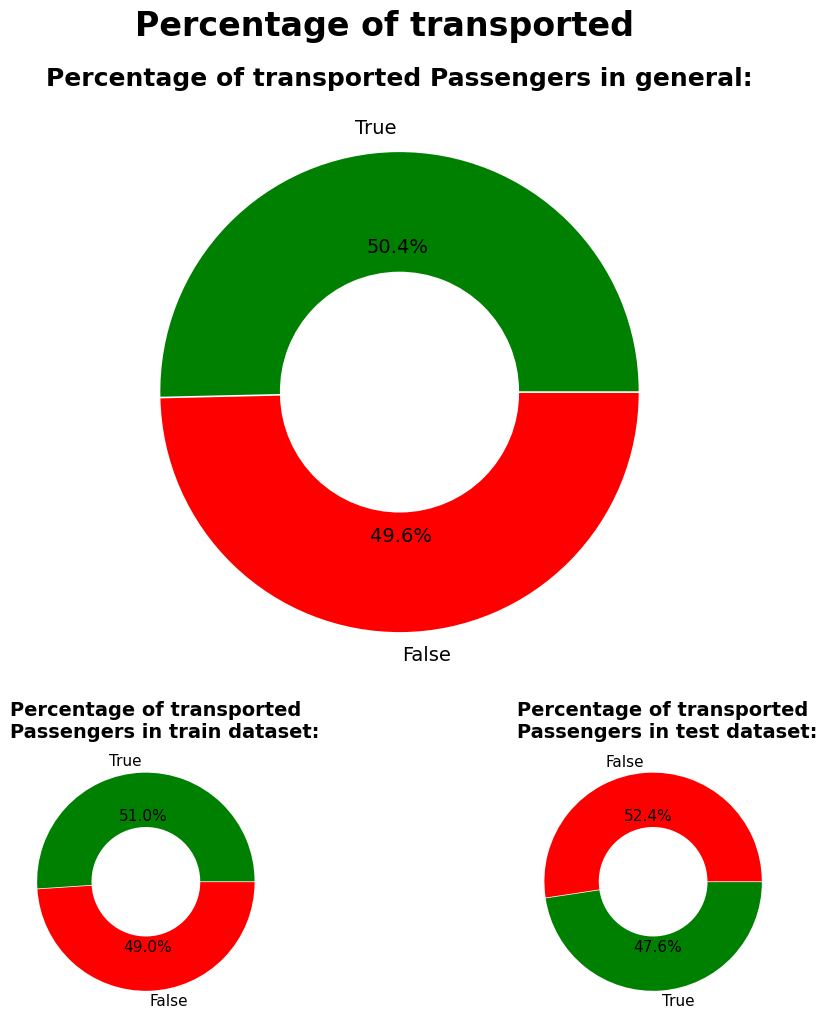

In [24]:
transported = df['Transported'].value_counts()
transported_train = D_train['Transported'].value_counts()
transported_test = D_test['Transported'].value_counts()

fig = plt.figure(figsize=(12,12))
gs = GridSpec(3, 2, figure=fig)

# Updating the rcParams in Matplotlib
# Making every title bold
plt.rcParams.update({'axes.titleweight': 'bold'})

explode = [0.007, 0]
autopct = '%1.1f%%' # In order to display as a percentage with one decimal point
label_color_dict = {
    'True': 'green',
    'False': 'red',
}

# Pie chart for all the data
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))
ax1.set_title("Percentage of transported Passengers in general:", fontsize=18)
colors = colors_match_labels(label_color_dict, transported.keys())
add_pie_chart(ax1, transported, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=14)

plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 11,
    'axes.titlelocation': 'left'
})

# Pie chart for the train data
ax2 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
ax2.set_title("Percentage of transported\nPassengers in train dataset:")
colors = colors_match_labels(label_color_dict, transported_train.keys())
add_pie_chart(ax2, transported_train, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=11)

# Pie chart for the test data
ax3 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
ax3.set_title("Percentage of transported\nPassengers in test dataset:")
colors = colors_match_labels(label_color_dict, transported_test.keys())
add_pie_chart(ax3, transported_test, explode=explode, colors=colors, autopct=autopct, wedges_width=0.5, textfont=11)

fig.suptitle("Percentage of transported", fontsize=24, fontweight='bold', y=0.95)
plt.show()

# Restoring rcParams back to default values
plt.rcParams.update(plt.rcParamsDefault)

ax1.clear()
ax2.clear()
ax3.clear()
fig.clear()

# delete unnecessary variables to reduce memory usage
delete_global_var('autopct')
delete_global_var('colors')
delete_global_var('label_color_dict')
delete_global_var('explode')
delete_global_var('transported')
delete_global_var('transported_train')
delete_global_var('transported_test')

<style>
    td {
        text-align: center;
        font-size: 90%;
    }

    .larger {
        color: orange;
        font-weight: bold;
    }

    .smaller {
        
    }
</style>
And as a table:
<table>
    <tr>
        <td style="border-style: none;"></td>
        <th>Teleported%</th>
        <th>Didn't%</th>
    </tr>
    <tr>
        <th>Entire Dataset</th>
        <td><span class="larger">50.4%</span></td>
        <td><span class="smaller">49.6%</span></td>
    </tr>
    <tr>
        <th>Train Dataset</th>
        <td><span class="larger">51%</span></td>
        <td><span class="smaller">49%</span></td>
    </tr>
    <tr>
        <th>Test Dataset</th>
        <td><span class="smaller">47.6%</span></td>
        <td><span class="larger">52.4%</span></td>
    </tr>
</table>

We can see that about half of the passangers have teleported to a different dimension.<br>
We can also see that the percentage of those who teleported is relatively unchanged when we split the data.

<h4 style="text-decoration: underline; font-weight: bold;">Picking the Desired Attributes</h4>

We want to take into account features that seem relevant.<br>
<br>
We'll start by making an expanded Dataframe. This expanded Dataframe will have some new columns that represent the different components<br>
of the columns in the original Dataframe that are in fact bundles of of attributes (i.e. 'PassengerId' and 'Cabin').<br>
The 'PassengerId' column bundles both the 'Group Id' of the passenger and their in-group identifier.<br>
The 'Cabin' column bundles together three values that comprise the cabin in which the passenger is staying, 'deck', 'num' and 'side':
<ul>
    <li>The 'deck' value, which takes the form of a letter, represents the deck on which the cabin is located.</li>
    <li>The 'num' value, which takes the form of a non-negative integer, represents the number of the cabin.</li>
    <li>
        The 'side' value, which can be either "Port" or "Starboard", represents the side of starship on which the cabin is located.
        <sub>
        <ul>
            <li>"Port" is the side of the spaceship that is on the <b>left</b> when one is facing forward.</li>
            <li>"Starboard" is the side of the spaceship that is on the <b>right</b> when one is facing forward.</li>
        </ul>
        </sub>
    </li>
</ul>
However, before we expand the Dataframe we must first deal with missing values, at least in those two columns that are the basis for<br>
the new columns we want to add.<br>
We need to fill them in order to avoid situations where we're attempting to split up non-existing data-pieces.<br>
For exaple, if we try to split a missing Cabin value in the Cabin column into the deck, num and side values that comprise it<br>
We will run into an exception, as there is nothing to split.<br>
We could avoid that by asking if there's something to split, before attempting to split it, but that would multiply the number of missing<br>
values in the dataframe, and we will have more work later when we will be forced to fill in missing values for the sake of classifing.<br>
<br>
<b>Let's refer back to a previous remark we made:</b><br>
<br>

> There are three methods that we may utilize in order to fill the blanks:
><style>
>    .grid {
>        display: grid;
>        grid-template-columns: max-content auto;
>        grid-column-gap: 1vw;
>    }
>
>    .underlined {
>        text-decoration: underline;
>    }
>
>    ol, ul {
>        margin-left: 2vw;
>    }
></style>
><sub>
><ol>
>    <li>
>        <div class="grid">
>            <span class="underlined">Most Common:</span>
>            <span>
>                We fill the blanks with the value that is the most common in that particular column <b>amongst all the entries in the Dataframe</b>.
>            </span>
>        </div>
>    </li>
>    <br>
>    <li>
>        <div class="grid">
>            <span class="underlined">Mean:</span>
>            <span>
>                We fill the blanks with the average value of the particular column. This can be used only when the values can be quantified and >averaged.
>            </span>
>        </div>
>    </li>
>    <br>
>    <li>
>        <div class="grid">
>            <span class="underlined">KNN Based:</span>
>            <span>
>                We fill a blank cell with the value that is the most common <b>amongst the k nearest neighbors</b>.<br>
>                There are main two variations to this:
>                <ul>
>                    <li>
>                        k nearest index-wise entries in the Dataframe
>                    </li>
>                    <li>
>                        k nearest entries according to other columns that are probably related or at least indicative of the column with the missing >value.
>                    </li>
>                </ul>
>            </span>
>        </div>
>    </li>
><ol>
></sub>

What are the pros and cons of each method?

<style>
    
    .underlined {
        text-decoration: underline;
    }

    .f-table {
        display: grid;
        grid-template-columns: repeat(2, 1fr);
        grid-template-rows: max-content 1fr;
        max-width: 96%;
        border-style: solid;
        border-width: calc(1px * 2);
        /* padding: 0.5em; */
        /* align-items: start; */
        /* align-content: end; */
        /* margin: max(1%, auto); */
        /* box-sizing: border-box; */
        /* justify-content: space-around; */
        /* grid-column-gap: 1vw; */
        /* gap: calc(var(--border-size) * 0.5); */
    }

    .f-table > :is(.f-td, .f-th) {
        display: flex;
        /* width: fit-content; */
        
        /* border-color: teal; */
        /* max-height: 99% */
        /* height: max(auto, fit-content); */
        /* height: 100%; */
        border-style: solid;
        border-width: 1px;
        border-color: inherit;
        /* flex: 1; */
        /* width:  */
        /* box-sizing: border-box; */
        /* padding-top: -1px; */
    }

    .f-table > :is(.f-td, .f-th):last-of-type {
        /* margin: 0 0 1% 0; */
    }

    .f-th {
        font-weight: bold;
        /* border-width: var(--border-size); */
        /* border-color: yellow; */
        /* background-color: yellow; */
        /* width: minmax(min-content, auto); */
        justify-content: center;
    }

    .f-td {
        /* border-style: solid; */
        /* border-width: var(--border-size); */
        /* border-color: teal; */
    }

    .f-list {
        display: grid;
        align-content: space-around;
        justify-items: space-around;
        row-gap: 1vw;
        /* height: calc(initial + 300px) */
        padding: 2vw 0;
        /* grid-template-row: max-content max-content max-content max-content max-content; */
        /* grid-template-row: 1fr 1fr 1fr 1fr 1fr; */
        /* grid-template-columns: auto; */
        /* grid-template-rows: max-content max-content max-content max-content max-content; */

        /* grid-template-rows: repeat(5, max-content)
        grid-auto-flow: column;
        grid-row-gap: auto; */
        
        /* background-color: teal; */
        /* align-items: space-between; */
        /* margin: 1vw; */
        /* padding: 0 1vw 0 0; */
        /* box-sizing:border-box; */
    }

    .f-oli, .f-uli {
        display: list-item;
        width: fit-content;
        /*margin: top | right | bottom | left */
        margin: 0 1em 0 2em;
    }

    .f-oli {
        list-style-type: decimal;
    }

    .f-uli {
        list-style-type: circle;
    }

    div.underlined.f-uli {
        margin-left: 8%;
        /* color: #FF4500; */
        color: teal;
        font-weight: bold;
    }

    .pros-list span.underlined:first-of-type {
        color: #228B22; # ForestGreen
    }

    .cons-list span.underlined:first-of-type {
        color: #B22222; # FireBrick
    }

    :is(.f-oli, .f-uli) > span.underlined:first-of-type {
        font-weight: bold;
    }

    .pros {
        color: green;
        /* color: #228B22; # ForestGreen */
    }

    .cons {
        color: red;
        /* color: #B22222; # FireBrick */
    }

    .pros-list {
        /* background-color: red; */
        /* border-style: solid; */
        /* border-color: green; */
    }

    .cons-list {
        /* background-color: blue; */
        /* border-style: solid; */
        /* border-color: purple; */
    }

</style>

<div class="underlined f-uli"><b>'Most Common' Method:</b></div>
<br>
<div class="f-table">
    <div class="f-th"><span class="pros">Pros:</span></div><div class="f-th"><span class="cons">Cons:</span></div>
    <div class="f-td pros-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">Easy to implement:</span> Just check which non-null value appears<br>
                the most and put it everywhere a value is missing.
            </div>
            <div class="f-oli">
                <span class="underlined">Light and Efficient:</span> Find the most common element once and apply it,<br>
                no more calculations needed.
            </div>
            <div class="f-oli">
                <span class="underlined">Atomic:</span> Does not rely on anything but the same column it is applied to.
            </div>
            <div class="f-oli">
                <span class="underlined">Applicable:</span> Can be applied to almost every column of every kind,<br>
                and it will work.
            </div>
            <div class="f-oli">
                <span class="underlined">Easily Modifiable:</span> Can have its behavior modified for different situations<br>
                which enables defaulting to either randomness or well-defined behavior when it is needed.
            </div>
        </div>
    </div>
    <div class="f-td cons-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">More of the same:</span> Makes the already dominant value dominate even more.
            </div>
            <div class="f-oli">
                <span class="underlined">Static and Unchanging:</span> Calculated once and no more.
                Therefore it doesn't affect itself, which means that every value assigned by it
                is effectively not part of the data for these calculations.
            </div>
            <div class="f-oli">
                <span class="underlined">No Correlations:</span> Doesn't account for possible or clear connections
                between the column and other columns or the entry and other entries.
            </div>
            <div class="f-oli">
                <span class="underlined">Non-Unique:</span> Incapable of generating and filling unique data, thus,
                it cannot be applied to a column that requires unique values.
            </div>
            <div class="f-oli">
                <span class="underlined">Needs a Clear Winner:</span> Cannot provide an answer to a situation where the column
                has more than one, single most common value (e.g. two values are just as common).
            </div>
        </div>
    </div>
</div>
<br>
<br>

<div class="underlined f-uli"><b>'Mean' Method:</b></div>
<br>
<div class="f-table">
    <div class="f-th"><span class="pros">Pros:</span></div><div class="f-th"><span class="cons">Cons:</span></div>
    <div class="f-td pros-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">Pro 1:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Pro 2:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Pro 3:</span> Short Explanation...
            </div>
        </div>
    </div>
    <div class="f-td cons-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">Con 1:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Con 2:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Con 3:</span> Short Explanation...
            </div>
        </div>
    </div>
</div>
<br>
<br>

<div class="underlined f-uli"><b>'KNN Based' Method:</b></div>
<br>
<div class="f-table">
    <div class="f-th"><span class="pros">Pros:</span></div><div class="f-th"><span class="cons">Cons:</span></div>
    <div class="f-td pros-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">Pro 1:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Pro 2:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Pro 3:</span> Short Explanation...
            </div>
        </div>
    </div>
    <div class="f-td cons-list">
        <div class="f-list">
            <div class="f-oli">
                <span class="underlined">Con 1:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Con 2:</span> Short Explanation...
            </div>
            <div class="f-oli">
                <span class="underlined">Con 3:</span> Short Explanation...
            </div>
        </div>
    </div>
</div>

<h2 style="color: red;">SAY WHICH ONE WAS CHOSEN AND Y</h2>

<h5>Most Common Method</h5>

In [25]:
#
def how_many_of_each_value_in_column(df, column, sort=False): # check if needed
    return df[column].value_counts(sort=sort)

#
def most_common_in_column(df, column):
    return df[column].dropna().mode()[0]

#
def fill_na_with_most_common_in_column(df, column, inplace: bool=False):
    most_common = most_common_in_column(df, column)
    if not inplace:
        df_new = df.copy()
        df_new[column].fillna(most_common, inplace=True)
        return df_new
    df[column].fillna(most_common, inplace=True)
    return None

<h5>Mean Method</h5>

In [26]:
#
def find_mean_for_column(df, column):
    return round(df[column].dropna().mean())

#
def fill_na_with_column_avg(df, column, inplace: bool=False):
    avg = find_mean_for_column(df, column)
    if not inplace:
        df_new = df.copy()
        df_new[column].fillna(avg, inplace=True)
        return df_new
    df[column].fillna(avg, inplace=True)
    return None

<sub>
(*) Note:<br>
Some columns require us to use a form of KNN to fill them in the way we think is best.<br>
This requires us to implement the KNN classifier already. In order to avoid making most of Part B inside Part 1,<br>
We will first fill and extract whatever data we can without implementing KNN, then we will start Part B and in it<br>
we will finish the filling and extracting job.
</sub>

For the sake of visual clarity, we will get rid of columns we already know we won't be using.<br>
We will explain our choices later on.

In [27]:
columns_we_need = ['PassengerId',
                   'CryoSleep',
                   'Cabin',
                   'Age',
                   'VIP',
                   'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                   'Transported']
our_df = extract_desired_features(df, columns_we_need)
delete_global_var('columns_we_need')
our_df

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,9278_01,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,9279_01,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,9280_01,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


We will fill in missing age values using the mean method:

In [28]:
fill_na_with_column_avg(our_df, "Age", inplace=True)
print_how_many_NaNs(our_df)

How many values are missing in each column:
PassengerId       0
CryoSleep       217
Cabin           199
Age               0
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64


While we will fully fill the 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' and 'VRDeck' values<br>
later using KNN, we can fill with zeros those values for passengers in who are in Cryo-Sleep:

In [29]:
our_df.loc[our_df['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0
our_df.loc[our_df['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
7,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
8679,0.0,0.0,0.0,0.0,0.0
8680,0.0,0.0,0.0,0.0,0.0
8681,0.0,0.0,0.0,0.0,0.0
8684,0.0,0.0,0.0,0.0,0.0


In order to fill in missing values in the Cabin column, we would like to take a look at one's group number, as it is very likely that members of the same group (which often indicates a family connection), will stay in the same cabin.<br>
Therefore, prior to filling the missing data, we need to break the 'PassengerId' column into the 'GroupId' and the 'InGroupId'.

In [30]:
column_to_split_and_remove: str = "PassengerId"
columns_to_split_into: list[str] = ["GroupId", "InGroupId"]
try:
    our_df[["GroupId", "InGroupId"]] = our_df.pop("PassengerId").str.split('_', expand=True).astype(int)
    # Moving the two new columns
    for idx, col_name in enumerate(columns_to_split_into):
        our_df.insert(idx, col_name, our_df.pop(col_name))
except KeyError:
    print("No such column!")
    print("No changes were made\n\n")
print("Altered DataFrame:")
our_df

Altered DataFrame:


,GroupId,InGroupId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,1,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,2,1,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,3,1,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,3,2,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,4,1,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,1,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,9278,1,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,9279,1,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,9280,1,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


In [31]:
print_how_many_NaNs(our_df)

How many values are missing in each column:
GroupId           0
InGroupId         0
CryoSleep       217
Cabin           199
Age               0
VIP             203
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Transported       0
dtype: int64


We would now like to use KNN in order to fill the missing data points in the 'Cabin' Column.<br>
But first we need to implement the KNN classifier.<br>
While we are tasked with implementing the classifier only in Part B, we thought it might be beneficial<br>
to utilize KNN already, hence we are implementing it here, in a glimpse into Part B.

---

<h3 style="text-decoration: underline; font-weight: bold;">A Taste of Part B: Implementing a KNN Classifier</h3>

<h4 style="font-weight: bold;">Functions for Distance Calculation</h4>

In [32]:
#
def euclidean_distance(p, q, sqrt: bool=False):
    """
    Calculates the euclidean distance between two points of the same number of dimensions.

    :param p: A point of n dimensions.
    :param q: A point of n dimensions.

    :return: The euclidean distance between point p and point q.
    """
    
    # if not (isinstance(p, np.ndarray) and isinstance(q, np.ndarray)): return -1
    TypeValidator.validate_variables_types((p, q), np.ndarray, ["p", "q"])
    if p.ndim != 1 or q.ndim != 1: return -1
    if p.size != q.size: return -1
    # dist = math.sqrt(np.square(np.subtract(q, p)).sum())
    dist = sum((q - p)**2)
    if sqrt:
        return sqrt(dist)
    return dist

#
def calc_euclidean_distances(p, points, sqrt: bool=False):
    """
    Calculates the euclidean distances between a point and multiple other points.

    :param p: A point of n dimensions.
    :param points: An array of points, each of n dimensions.

    :return: An array that contains the distance between the point p and each point in points.
    """
    return np.array([euclidean_distance(p, point, sqrt) for point in points])


<h4 style="font-weight: bold;">Functions for Classifying Data</h4>

In [33]:
#
def get_indices_of_k_smallest(k, arr):
    """
    Finds the indices of the k smallest elements in an array.

    :param k: The number of smallest elements to find.
    :param arr: An array.

    :return: An unsorted array that contains the indices of the k smallest elements in arr.
    """
    if k < 0: return -1
    TypeValidator.validate_variables_types([arr], np.ndarray, "arr")
    if arr.ndim != 1: return -1
    if k > arr.size: return -1
    if k == arr.size: return np.arange(k)
    return np.argpartition(arr, k)[:k]

#
def most_common_amongst_indices(indices, arr):
    """
    Finds the most common element amongst specified indices of an array.

    :param indices: An array of indices to account for in the array.
    :param arr: An array.

    :return: The most common element found within the specified indices of the array arr.
    """
    in_indices = [arr[idx] for idx in indices if idx>=0 and idx<arr.size]
    return max(set(in_indices), key = in_indices.count)

#
def most_common_amongst_indices2(indices, arr):
    """
    Finds the most common element amongst specified indices of an array.
    Utilizes a little less efficient and less pretty, yet more simple way of achieving that.

    :param indices: An array of indices to account for in the array.
    :param arr: An array.

    :return: The most common element found within the specified indices of the array arr.
    """
    in_indices = []
    for idx in indices:
        if idx>=0 and idx<arr.size:
            in_indices.append(arr[idx])
    return max(set(in_indices), key = in_indices.count)


<h4 style="font-weight: bold;">Functions for the KNN Bigger Picture</h4>

In [34]:
#
def KNN_classification_for_single_entry(entry, table, k, classifications_column: Optional[str]=None):
    """
    Classifies a single entry using KNN, based on pre-classified examples.

    :param entry: An instance to classify.
    :param table: A numpy.ndarray or a pandas.DataFrame of pre-classified examples.
    :param k: The number of the nearest neighbors to take into an account when classifing.

    :return: The KNN classification for the entry.

    :error: returns TypeError if argument table is not an instance of either numpy.ndarray or pandas.DataFrame
    """
    # examples_features, examples_classifications = separate_features_and_classifications_for_df_or_ndarray(table)
    examples_features, examples_classifications = separate_features_and_classifications(table, classifications_column)
    indices_of_k_closest_neighbors = get_indices_of_k_smallest(k, calc_euclidean_distances(entry, examples_features))
    classification = most_common_amongst_indices(indices_of_k_closest_neighbors, examples_classifications)
    return classification

#
def KNN_classification_for_multiple_entries(entries, examples, k, classifications_column: Optional[str]=None):
    # print(f'Entries in function \'KNN_classification_for_multiple_entries\': {entries}.') #
    # for idx, entry in enumerate(entries):
    #     print(f'Entry #{idx+1} in function \'KNN_classification_for_multiple_entries\': {entry}.')
    classifications = np.array([KNN_classification_for_single_entry(entry, examples, k, classifications_column) for entry in entries])
    return classifications

#
def classify_entries_using_KNN(entries, examples, k, classifications_column: Optional[str]=None):
    if isinstance(entries, pd.DataFrame):
        entries = entries.to_numpy()
    # print(f'Entries in function \'classify_entries_using_KNN\': {entries}.')
    # np.c_ translates slice objects to concatenation along the second axis.
    # np.c_[np.array([1,2,3]), np.array([4,5,6])]
    # will result in :
    # array([[1, 4],
    #        [2, 5],
    #        [3, 6]])
    classified_instances = np.c_[entries, KNN_classification_for_multiple_entries(entries, examples, k, classifications_column)]
    # result will look like:
    # array([[entry1, classification_for_entry1],
    #        [entry2, classification_for_entry2],
    #        [entry3, classification_for_entry3]])
    return classified_instances


<h4 style="font-weight: bold;">KNN Function for Filling Missing Values</h4>

In [35]:
from collections import defaultdict
#
def fill_missing_values_using_KNN(df: pd.DataFrame,
                                  features_to_fill: dict[str, list[str]],
                                  k: int,
                                #   max_tries_to_classify: int=30
                                  ) -> tuple[pd.DataFrame, list[str]]:
    if not isinstance(df, pd.DataFrame):
        raise TypeError(f'Argument \'df\' must be of type pd.DataFrame!\nThe type you\'ve given is {type(df)}.')
    if df.empty or not features_to_fill or k <= 0:
        return df
    filled_df: pd.DataFrame = df.copy()
    features: dict[str, list[str]] = features_to_fill.copy()
    cannot_classify_columns: list[str] = []
    # cannot_classify_counters = defaultdict(int)
    changed: bool = False
    while filled_df[features].isnull().values.any():
        changed = False
        for attr in list(features):
            # print(f'Working on KNN for column: \'{attr}\'.') ##############
            if filled_df[filled_df[attr].isna()].empty: # If there is nothing to classify
                features.pop(attr) # no need to try and classify it again
                # print(f'No more entries to classify in column \'{attr}\'.')
                break
            if filled_df[filled_df[attr].notna()].empty: # If there is nothing to classify with (no examples)
                features.pop(attr) # no need to try and classify it again
                cannot_classify_columns.append(attr)
                break
            df_for_attr = extract_desired_features(filled_df, features[attr] + [attr]).dropna(subset=features[attr])
            if df_for_attr.empty:
                if not set(cannot_classify_columns).isdisjoint(features[attr]):
                    features.pop(attr)
                    cannot_classify_columns.append(attr)
                    break
                # print(f'Cannot classify column \'{attr}\' because there are no values without NaNs in relevant columns.')
                # cannot_classify_counters[attr] += 1
                # if cannot_classify_counters[attr] == max_tries_to_classify:
                #     print(f'Tried to classify column \'{attr} {max_tries_to_classify} times to no avail\'')
                #     cannot_classify_columns += features
                #     return filled_df, cannot_classify_columns
                break
            entries = df_for_attr[df_for_attr[attr].isna()].drop(columns=attr)
            if entries.empty: # All entries currently have a missing value that is necessary for the classification
                # cannot_classify_counters[attr] += 1
                # if cannot_classify_counters[attr] == max_tries_to_classify:
                #     print(f'Tried to classify column \'{attr} {max_tries_to_classify} times to no avail\'')
                #     cannot_classify_columns += features
                #     return filled_df, cannot_classify_columns
                # print(f'Cannot currently classify the column \'{attr}\', because there are currently no classifiable entries.')
                break
            entries_indices = entries.index
            # print(f'Number of entries we can fill the \'{attr}\' column for = {len(entries_indices)};') #############
            # examples = df_for_attr[df_for_attr[attr].notna()]
            examples = df_for_attr.loc[~df_for_attr.index.isin(entries_indices)]
            if examples.empty:
                # print(f'Cannot classify column \'{attr}\' because there are no values to reference.')
                # cannot_classify_counters[attr] += 1
                # if cannot_classify_counters[attr] == max_tries_to_classify:
                #     print(f'Tried to classify column \'{attr} {max_tries_to_classify} times to no avail\'')
                #     cannot_classify_columns += features
                #     return filled_df, cannot_classify_columns
                break
            examples_len = len(examples.index)
            classifications = KNN_classification_for_multiple_entries(entries.to_numpy(), examples, k if k <= examples_len else examples_len, attr)
            filled_df.loc[entries_indices, attr] = classifications
            changed = True
            # end of for loop
        if not changed:
            # print("Went through a whole cycle without classifing")
            cannot_classify_columns += features
            return filled_df, cannot_classify_columns
        if not features: # If the dictionary is empty
            return filled_df, cannot_classify_columns
        # end of while loop
    return filled_df, cannot_classify_columns

---

<h3 style="text-decoration: underline; font-weight: bold;">Back to Part A: Filling the Missing Values</h3>

We want to use KNN based on the Group Number of every passenger.<br>
In order to do that we need to choose a fitting K value<br>
We may use the size of the group of that specific passenger.<br>
Notice that, since we are not including the passenger in the example set for the KNN, we will always take into account<br>
at least one passenger which is not from the group. This is fine as long as that other passenger is similiar enough to<br>
the passenger we are looking to fill a value for.

In [36]:
group_sizes = our_df['GroupId'].value_counts(sort=False)
group_sizes

1       1
2       1
3       2
4       1
5       1
       ..
9275    3
9276    1
9278    1
9279    1
9280    2
Name: GroupId, Length: 6217, dtype: int64

We can also use a static k value for all the passengers.<br>
The average group size is likely to be a good value.<br>
It has it's flaws, as some passengers will take into account other passengers whom are not from their group,<br>
while other passengers will not take into account all their group members.

In [37]:
avg_group_size = math.ceil(group_sizes.mean())
print(f'The average group size is {avg_group_size}')

The average group size is 2


In [38]:
our_df['GroupSize'] = our_df.groupby('GroupId')['GroupId'].transform('count')
our_df

,GroupId,InGroupId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize
0,1,1,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1
1,2,1,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1
2,3,1,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2
3,3,2,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2
4,4,1,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,1,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1
8689,9278,1,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,False,1
8690,9279,1,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1
8691,9280,1,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,2


Before using the KNN classifier on the dataframe we need to quantify the values we will use as features in it,<br>
so we may calculate the euclidean distances between entries.

<p style="color: violet; font-size: 1.5em;">
For each feature we want to get using KNN we need to create a dataframe that includes all the features we want to consider, as well as the feature we are looking for itself.<br>
We then need to split it into two dataframes (or np.arrays - check this!), one that has all the rows that have NaN in that feature, and the other of all the rest.<br>
Make sure you take out the column of that specific feature from the dataframe that has the NaNs in it.<br>
Make sure you remove, or deal in other ways with any example (row) in the non-NaN dataframe, that has a NaN in one of the columns of the features we want to take into account.<br>
<br>
After you've classified the entries - insert them to the pseudo-original dataframe (the one before the first one mentioned in this paragraph)!<br>
You could use the combination of GroupId and InGroupId to get a unique key for every row (there might be better options).
<br>
<br>
<b style="text-decoration: underline;">ONLY - BUT ONLY</b> if you see it is crucial: The entire thing can be made as a function that takes a dictionary: dict[str, ArrayLike[str]] (has column names for keys - the columns we want to get via KNN, and ArrayLike values that are the lists of the features we want to use for the matching key). If done like this - make sure to pass the pseudo-original dataframe, so that it includes all the features that might be asked for.
</p>

In [39]:
print_how_many_NaNs(our_df)

How many values are missing in each column:
GroupId           0
InGroupId         0
CryoSleep       217
Cabin           199
Age               0
VIP             203
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Transported       0
GroupSize         0
dtype: int64


In [40]:
features_per_feature: dict[str, list[str]] = {
    # 'CryoSleep' : ["GroupId", "InGroupId", "Age", "VIP", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    'CryoSleep' : ["GroupId", "InGroupId", "Age", "VIP"],
    'VIP' : ["GroupId", "InGroupId", "Age", "CryoSleep", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    'RoomService' : ["GroupId", "InGroupId", "Age", "VIP", 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
    'FoodCourt' : ["GroupId", "InGroupId", "Age", "VIP", 'RoomService', 'CryoSleep', 'ShoppingMall', 'Spa', 'VRDeck'],
    'ShoppingMall' : ["GroupId", "InGroupId", "Age", "VIP", 'RoomService', 'FoodCourt', 'CryoSleep', 'Spa', 'VRDeck'],
    'Spa' : ["GroupId", "InGroupId", "Age", "VIP", 'RoomService', 'FoodCourt', 'ShoppingMall', 'CryoSleep', 'VRDeck'],
    'VRDeck' : ["GroupId", "InGroupId", "Age", "VIP", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'CryoSleep'],
}

our_df, _ = fill_missing_values_using_KNN(our_df, features_per_feature, k=avg_group_size)

In [41]:
our_df

,GroupId,InGroupId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize
0,1,1,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1
1,2,1,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1
2,3,1,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2
3,3,2,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2
4,4,1,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,1,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1
8689,9278,1,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,False,1
8690,9279,1,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1
8691,9280,1,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,2


In [42]:
print_how_many_NaNs(our_df)

How many values are missing in each column:
GroupId           0
InGroupId         0
CryoSleep         7
Cabin           199
Age               0
VIP              14
RoomService      11
FoodCourt        12
ShoppingMall      9
Spa               9
VRDeck           10
Transported       0
GroupSize         0
dtype: int64


In [43]:
for key in features_per_feature:
    how_to_fill = fill_na_with_most_common_in_column if key in ['CryoSleep', 'VIP'] else fill_na_with_column_avg
    how_to_fill(our_df, key, inplace=True)

delete_global_var('features_per_feature')
delete_global_var('how_to_fill')
print_how_many_NaNs(our_df)

How many values are missing in each column:
GroupId           0
InGroupId         0
CryoSleep         0
Cabin           199
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
GroupSize         0
dtype: int64


Now that we have all other features but 'Cabin', we may use KNN to get it:

We will exclude the 'Transported' column because it is our final goal, and we don't want to use it here to avoid "contaminating"<br>
our final classifications. We don't want to create a loop, or rather a loophole, where we use the thing we are looking for to<br>
alter the data we eventually are going to use to find it.

In [44]:
features_for_cabin = {'Cabin': our_df.columns.drop(['Cabin', 'GroupSize', 'Transported']).to_list()}
our_df, _ = fill_missing_values_using_KNN(our_df, features_for_cabin, k=avg_group_size)
delete_global_var('features_for_cabin')
our_df

,GroupId,InGroupId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize
0,1,1,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1
1,2,1,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1
2,3,1,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2
3,3,2,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2
4,4,1,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,1,False,A/98/P,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1
8689,9278,1,True,G/1499/S,18.0,False,0.0,0.0,0.0,0.0,0.0,False,1
8690,9279,1,False,G/1500/S,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1
8691,9280,1,False,E/608/S,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,2


In [45]:
print_how_many_NaNs(our_df)

There are no more NaN values in the Dataframe.


Now that we have finally filled all the missing values in the 'Cabin' column we may split it into 'Deck', 'CabinNumber' and 'Side':

In [46]:
try:
    our_df[["Deck", "CabinNumber", "Side"]] = our_df.pop("Cabin").str.split('/', expand=True)
    our_df["CabinNumber"] = our_df["CabinNumber"].astype(int)
except KeyError:
    print("No such column!")
    print("No changes were made\n\n")
print("Altered DataFrame:")
our_df

Altered DataFrame:


,GroupId,InGroupId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupSize,Deck,CabinNumber,Side
0,1,1,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,2,1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,0,S
2,3,1,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,0,S
3,3,2,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,0,S
4,4,1,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276,1,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,A,98,P
8689,9278,1,True,18.0,False,0.0,0.0,0.0,0.0,0.0,False,1,G,1499,S
8690,9279,1,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,1,G,1500,S
8691,9280,1,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,2,E,608,S


<style>
    h5 {
        text-decoration: underline;
        font-size: 95%;
    }

    ol {
        border-style: solid;
    }

    li {
        font-size: 80%;
    }
    
    .bolded {
        font-weight: bold;
    }

    .underlined {
        text-decoration: underline;
    }
</style>

<h5>Pre-Existing Attributes We Picked:</h5>
<ol>
    <li><span class="underlined bolded">Cryosleep :</span> We chose...</li>
    <li><span class="underlined bolded">Age :</span> We chose...</li>
    <li><span class="underlined bolded">VIP :</span> We chose...</li>
    <li><span class="underlined bolded">Room Service :</span> We chose...</li>
    <li><span class="underlined bolded">Food Court :</span> We chose...</li>
    <li><span class="underlined bolded">Shopping Mall :</span> We chose...</li>
    <li><span class="underlined bolded">Spa :</span> We chose...</li>
    <li><span class="underlined bolded">VR Deck :</span> We chose...</li>
</ol>

<h5>Pre-Existing Attributes We Forgone:</h5>
<ol>
    <li><span class="underlined bolded">Passenger ID :</span> We chose...</li>
    <li><span class="underlined bolded">Home Planet :</span> We chose...</li>
    <li><span class="underlined bolded">Destination :</span> We chose...</li>
    <li><span class="underlined bolded">Cabin :</span> We chose...</li>
</ol>

<h5>Attributes We've Added:</h5>
<ol>
    <li><span class="underlined bolded">Deck :</span> We chose...</li>
    <li><span class="underlined bolded">Cabin Number :</span> We chose...</li>
    <li><span class="underlined bolded">Side :</span> We chose...</li>
    <li>
        <span class="underlined bolded">Out of Cabin Expenses :</span> We think that the amount of money one spends<br>
        out of their cabin might be indicative of how often did they leave the cabin,<br>
        or how much time did they spend out of the cabin.<br>
        This information might tell us if an factor in whether somebody<br>
        teleports or not is related to how much time do they spend in their room.
    </li>
</ol>

In [47]:
features_list = ["CryoSleep",
                 "Age",
                 "VIP",
                 "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
                 "Deck", "CabinNumber", "Side",
                 "Transported"]

In [48]:
our_df = extract_desired_features(our_df, features_list, disregard_capitalization=True)
our_df["Transported"] = our_df.pop("Transported") # move the "Transported" column to the back
print("The Dataframe with the raw features we chose:")
our_df

The Dataframe with the raw features we chose:


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side,Transported
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,True
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,False


Now that we have chosen the attributes, we may look to quantify them.

In [49]:
our_df['Deck'] = our_df['Deck'].apply(lambda c: ord(c) - ord('A') + 1)
our_df['Side'] = our_df['Side'].apply(lambda side: True if side == 'P' else False if side == 'S' else np.nan)
our_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side,Transported
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,2,0,True,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,6,0,False,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,1,0,False,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,1,0,False,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,6,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,1,98,True,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,7,1499,False,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,7,1500,False,True
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,5,608,False,False


In [50]:
print_how_many_NaNs(our_df)

There are no more NaN values in the Dataframe.


In [51]:
D_train, D_test = select_train_and_test_by_train_percentage(our_df, train_percentage)

In [52]:
D_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side,Transported
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,2,0,True,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,6,0,False,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,1,0,False,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,1,0,False,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,6,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6949,True,26.0,False,0.0,0.0,0.0,0.0,0.0,5,477,True,True
6950,True,43.0,False,0.0,0.0,0.0,0.0,0.0,7,1186,True,False
6951,False,20.0,False,9.0,0.0,1540.0,0.0,0.0,6,1416,False,False
6952,False,19.0,False,40.0,0.0,77.0,572.0,0.0,6,1417,False,False


In [53]:
D_test

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,CabinNumber,Side,Transported
6954,True,17.0,False,0.0,0.0,0.0,0.0,0.0,7,1198,False,True
6955,False,62.0,False,240.0,0.0,0.0,586.0,10.0,7,1190,True,False
6956,True,32.0,False,0.0,0.0,0.0,0.0,0.0,7,1191,True,False
6957,True,37.0,False,0.0,0.0,0.0,0.0,0.0,7,1192,True,False
6958,False,40.0,False,0.0,0.0,0.0,7.0,782.0,5,478,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41.0,True,0.0,6819.0,0.0,1643.0,74.0,1,98,True,False
8689,True,18.0,False,0.0,0.0,0.0,0.0,0.0,7,1499,False,False
8690,False,26.0,False,0.0,0.0,1872.0,1.0,0.0,7,1500,False,True
8691,False,32.0,False,0.0,1049.0,0.0,353.0,3235.0,5,608,False,False


<h3 style="text-decoration: underline; font-weight: bold;">Part B - This Time For Real: How Good Is Our KNN Classifier</h3>

<h4 style="font-weight: bold;">Functions for Accuracy Calculations</h4>

In [54]:
#
def KNN_decimal_accuracy(KNN_classified, original_classified, classifications_column: Optional[str]=None):
    return (KNN_classified[:, -1] == original_classified[:, -1]).mean()

#
def KNN_percentage_accuracy(KNN_classified, original_classified, classifications_column: Optional[str]=None):
    return 100*(KNN_classified[:, -1] == original_classified[:, -1]).mean()

#
def get_indices_of_max_accuracy(accuracies):
    max_accuracy = accuracies.max()
    return np.where(accuracies == max_accuracy)

<h4 style="font-weight: bold;">Functions for Classification and Accuracy Combined</h4>

In [55]:
#
def KNN_classify_and_check_accuracy(entries, examples, k, accuracy_reference=None, classifications_column: Optional[str]=None):
    classified_instances = classify_entries_using_KNN(entries, examples, k, classifications_column)
    if accuracy_reference is None:
        accuracy_reference = examples
    accuracy = KNN_percentage_accuracy(classified_instances, accuracy_reference, classifications_column)
    return classified_instances, accuracy

# a rather slow function - a lot of computations and iterations needed
def KNN_accuracies_for_range_of_k(entries, examples, k_values, accuracy_reference=None, classifications_column: Optional[str]=None):
    if accuracy_reference is None:
        accuracy_reference = examples
    accuracies = np.array([KNN_classify_and_check_accuracy(entries, examples, k, accuracy_reference, classifications_column)[1] for k in k_values])
    return accuracies

<h4 style="font-weight: bold;">Functions for Average Across Multiple Randomizations of Train and Test</h4>

In [56]:
# an incredibly slow function (probably inefficient) - takes about 4 minutes on my computer when number_of_randomizations = 100 !!!
def average_accuracies_for_multiple_randomized_train_and_test(df,
                                                              train_part_deciaml,
                                                              k_values,
                                                              number_of_randomizations,
                                                              classifications_column: Optional[str]=None):
    train_avg_accuracies = np.zeros(k_values.size)
    test_avg_accuracies = np.zeros(k_values.size)
    train_times_k_was_max_accuracy = get_dictionary_from_1darray(k_values)
    test_times_k_was_max_accuracy = get_dictionary_from_1darray(k_values)
    
    for i in range(number_of_randomizations):
        train, test = map(np.array, select_train_and_test_by_train_percentage(df, train_part_deciaml))
        train_accuracies = KNN_accuracies_for_range_of_k(train[:, :-1], train, k_values, classifications_column)
        test_accuracies = KNN_accuracies_for_range_of_k(test[:, :-1], train, k_values, test, classifications_column)
        train_times_k_was_max_accuracy.update({
            k: train_times_k_was_max_accuracy[k]+1 for k in k_values[get_indices_of_max_accuracy(train_accuracies)]
            })
        test_times_k_was_max_accuracy.update({
            k: test_times_k_was_max_accuracy[k]+1 for k in k_values[get_indices_of_max_accuracy(test_accuracies)]
            })
        train_avg_accuracies = np.add(train_avg_accuracies, train_accuracies)
        test_avg_accuracies = np.add(test_avg_accuracies, test_accuracies)

    return (
        train_avg_accuracies/number_of_randomizations,
        test_avg_accuracies/number_of_randomizations,
        find_most_accurate_k(train_times_k_was_max_accuracy, number_of_randomizations),
        find_most_accurate_k(test_times_k_was_max_accuracy, number_of_randomizations)
        )

#
def find_most_accurate_k(times_k_was_max_accuracy, total_times_checked):
    max_val = max(times_k_was_max_accuracy.values())
    return np.array([k for k in times_k_was_max_accuracy if times_k_was_max_accuracy[k]==max_val]), 100*(max_val/total_times_checked)

<h4 style="font-weight: bold;">Functions for Visualizing Results</h4>

In [57]:
#
def print_accuracy_for_k(accuracy, k):
    accuracy = int(accuracy) if accuracy.is_integer() else round(accuracy, 4)
    print(f'For K={k}, there is {accuracy}% accuracy.')

#
def print_accuracy_per_k(accuracies, k_values, accuracy_of_what=None):
    print("----------------------------------")
    if isinstance(accuracy_of_what, str): print(f'Accuracy of {accuracy_of_what} per K:\n')
    for accuracy, k in zip(accuracies, k_values):  
        print_accuracy_for_k(accuracy, k)
    print("----------------------------------")

#
def print_best_ks_on_average(best_ks, percentage):
    print(f'On average the best K values were:')
    for k in best_ks: print(f'K={k}')
    percentage = int(percentage) if percentage.is_integer() else round(percentage, 4)
    print(f'being the K values with the highest accuracy roughly {percentage}% of the times.')

#
def graph_accuracies_of_train_and_test_over_k(train_accuracies, test_accuracies, k_arr):
    fig = plt.figure()
    ax = plt.subplot(111)

    plt.plot(k_arr, train_accuracies, color='darkorange', label="Accuracy of train", marker='o')
    plt.plot(k_arr, test_accuracies, color='blue', label="Accuracy of test", marker='o')
    indices_of_max_train = get_indices_of_max_accuracy(train_accuracies)
    indices_of_max_test = get_indices_of_max_accuracy(test_accuracies)
    plt.plot(k_arr[indices_of_max_train], train_accuracies[indices_of_max_train], 'o', color='red')
    plt.plot(k_arr[indices_of_max_test], test_accuracies[indices_of_max_test], 'o', color='red')
    # plt.plot(np.take(k_arr, indices_of_max_test), np.take(test_accuracies, indices_of_max_test), 'o', color='red')
    # plt.vlines(x = np.take(k_arr, list(set(np.append(indices_of_max_train, indices_of_max_test)))), ymin = 0, ymax = 101, colors = 'red', ls = '--')
    # plt.vlines(x = k_arr[np.unique([indices_of_max_train, indices_of_max_test])], ymin = 0, ymax = 101, colors = 'red', ls = '--')
    plt.vlines(x = k_arr[indices_of_max_train], ymin = 0, ymax = 101, colors = 'red', ls = '--')
    plt.vlines(x = k_arr[indices_of_max_test], ymin = 0, ymax = 101, colors = 'red', ls = '--')
    plt.xticks(k_arr)
    plt.yticks(np.arange(0, 101, 5))

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*1.5, box.height*1.5])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel(f'K')
    plt.ylabel(f'Accuracy')
    plt.title(f'Accuracies of train and test as a function of K')

    plt.show()
    return

<h4 style="text-decoration: underline; font-weight: bold;">Training a KNN classifier with k=3</h4>

In [58]:
K = 3

In [59]:
# took 8 minutes and 50 seconds to complete this cell alone!!!
train_as_array = D_train.to_numpy()
D_train_for_3, accuracy_for_3 = KNN_classify_and_check_accuracy(train_as_array[:, :-1], train_as_array, k=K, accuracy_reference=train_as_array)
accuracy_for_3

85.56226632154156

---

<h3 style="text-decoration: underline; font-weight: bold;">Part C - Logistic Regression</h3>

In [60]:
x_train = D_train.drop(columns="Transported").to_numpy()
y_train = D_train["Transported"].to_numpy()
y_train.reshape((y_train.shape[0], 1))
x_train.shape

(6954, 11)

In [61]:
#
def generate_weights(num_of_predictors, fill_ones: bool=False, randomize: bool=False) -> np.ndarray:
    if randomize:
        W = np.random.rand(num_of_predictors+1)
    else:
        W = np.ones(num_of_predictors+1) if fill_ones else np.zeros(num_of_predictors+1)
    return W

In [62]:
#
def sigmoid(X):
    return 1/(1+np.exp(-X))

#
def hypothesis(W, x):
    return sigmoid(W[1:].T@x + W[0])

In [63]:
#
def gradient_step(a, W, X, Y):
    gradient = 0
    for n, x_n in enumerate(X):
        prediction = hypothesis(W, x_n)
        diff_pred_actual = prediction - Y[n]
        # gradient += [diff_pred_actual, *(x_n * diff_pred_actual)]
        gradient += np.append(diff_pred_actual, x_n * diff_pred_actual)
    # gradient /= len(X) # ???
    return W - (a * gradient)

#
def gradient_descent(a, T, W, X, Y):
    for _ in range(T):
        W = gradient_step(a, W, X, Y)
    return W

#
def gradient_descent_log(a, T, W, X, Y) -> np.ndarray:
    W_updates_log = [W]
    for _ in range(T):
        W_updates_log.append(gradient_step(a, W, X, Y))
    return np.array(W_updates_log)

#
def gradient_descent_with_log(a, T, W, X, Y) -> tuple:
    W_updates_log = [W]
    for _ in range(T):
        W_updates_log.append(W := gradient_step(a, W, X, Y))
    return W, np.array(W_updates_log)


In [64]:
#
def logistic_regression_classifier(W, X):
    predictions = []
    for x_n in X:
        predictions.append(hypothesis(W, x_n))
    return np.array(predictions)

In [65]:
#
def classify_using_threshold(threshold, predictions):
    classifications = np.zeros(len(predictions))
    classifications[predictions > threshold] = 1
    return classifications

In [66]:
#
def classify_using_logistic_regression(W, X, threshold: float=0.5):
    predictions = logistic_regression_classifier(W, X)
    return classify_using_threshold(threshold, predictions)

In [67]:
#
def calibrate_then_classify_using_logistic_regression(X, Y, a: float=0.001, T: int=100, W=None, threshold: float=0.5):
    if W is None:
        W = generate_weights(X.shape[1])
    W_calibrated = gradient_descent(a, T, W, X, Y)
    return classify_using_logistic_regression(W_calibrated, X, threshold)

<h4>Accuracy Functions</h4>

In [68]:
#
def accuracy(predicted_ys, actual_ys):
    return (predicted_ys == actual_ys).mean()

#
def format_accuracy(accuracy: float) -> str:
    return f'{accuracy:.3%}'

<h4>Classification and Accuracy Combined Functions</h4>

In [69]:
#
def classify_and_calc_accuracy(W, X, Y, threshold: float=0.5):
    classifications = classify_using_logistic_regression(W, X, threshold)
    return classifications, accuracy(classifications, Y)

#
def calibrate_then_classify_and_calc_accuracy(X, Y, a: float=0.001, T: int=100, W=None, threshold: float=0.5):
    classifications = calibrate_then_classify_using_logistic_regression(X, Y, a, T, W, threshold)
    return classifications, accuracy(classifications, Y)


Let's do a little test:

In [70]:
predictions, accur = calibrate_then_classify_and_calc_accuracy(x_train, y_train, a=0.001, T=100, W=None, threshold=0.5)
# predictions = 
predictions.shape

(6954,)

In [71]:
print(f'Accuracy is: {format_accuracy(accur)}')

Accuracy is: 68.608%


This isn't great but we also didn't give any thought to the values given and we told the function to generate the weights

In [72]:
#
def get_wlogs_dataframe(wlogs) -> pd.DataFrame:
    return pd.DataFrame(wlogs, columns=[f'w{i}' for i in range(wlogs.shape[1])])

#
def accuracy_for_wlogs(wlogs, X, Y, threshold: float=0.5):
    return np.array([classify_and_calc_accuracy(w_log, X, Y, threshold)[1] for w_log in wlogs])

#
def graph_accuracies_per_t(accuracies_of_wlogs, as_percentage: bool=False, title: Optional[str]="Accuracy per t"):
    iterations = range(len(accuracies_of_wlogs))
    if as_percentage:
        accuracies_of_wlogs *= 100

    _, ax = plt.subplots(figsize=(7, 7))
    
    ax.plot(iterations, accuracies_of_wlogs, color='b', label='Accuracies')
    plt.title(title)

    plt.xlim(-1, (iterations[-1] * 1.02))
    plt.xlabel("t (iteration)")
    plt.xticks(np.arange(iterations[-1]+1, step=5))

    y_up_lim = 1 if not as_percentage else 100
    plt.ylim(0, y_up_lim * 1.01)
    plt.ylabel("Accuracy" if not as_percentage else "Accuracy (%)")
    plt.yticks(np.arange(y_up_lim * 1.01, step=y_up_lim/10))

    acc_label = lambda acc, str: f'{str} Accuracy={acc:.3}' if not as_percentage else f'{str} Accuracy={acc:.3%}'

    max_acc_val = accuracies_of_wlogs[np.argmax(accuracies_of_wlogs)]
    ax.axhline(y=max_acc_val, color='r', linestyle='-', label=acc_label(max_acc_val, "Max"))
    mean_acc_val = accuracies_of_wlogs.mean()
    ax.axhline(y=mean_acc_val, color='m', linestyle='-', label=acc_label(mean_acc_val, "Average"))

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid()
    plt.show()

In [73]:
a = 0.001
T = 100
W = generate_weights(x_train.shape[1]) # Will preduce an all zeros W
calibrated_W, Wlogs = gradient_descent_with_log(a, T, W, x_train, y_train)
print(f'The calibrated weights:\n{calibrated_W}')
print("\nThe weights per iteration:")
get_wlogs_dataframe(Wlogs)

The calibrated weights:
[13.703329386647917 33.75645273941322 317.10431054298056
 0.4010004099480482 -588.8850386804426 672.6315527835899
 295.67937738661584 -853.2750000000008 -862.2104999963105
 -3.355776909029336 1265.5395345477725 -9.479025827317487]

The weights per iteration:


,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.073,0.777,-1.6095,-0.015,-537.732,305.6275,28.1625,-842.626,-780.9785,-0.2585,34.766,-0.1595
2,-0.249358,0.351772,-5.690728,-0.007,-345.303,314.2785,191.2835,-675.263,-623.9115,-2.878553,-109.879,-0.464631
3,2.197642,2.344772,58.576272,0.011,-194.016,203.4335,127.3455,-541.179,-497.4855,9.710447,1104.668,0.588369
4,0.102642,1.904772,0.106272,-0.007,-804.733,-49.7405,-252.8925,-725.399,-681.0095,-3.456553,-291.885,-0.633631
...,...,...,...,...,...,...,...,...,...,...,...,...
96,11.556547,31.31667,267.922009,0.396,-758.101039,1761.155553,262.870377,-766.554,-785.3735,-13.381342,67.525588,-9.910808
97,10.493547,30.87767,239.150009,0.373,-706.514039,773.377553,90.568377,-1122.709,-1089.7415,-19.417342,-368.905412,-10.587808
98,13.108547,32.76167,307.012009,0.391,-537.556039,494.806553,437.644377,-1020.237,-1010.6975,-5.375342,1048.102588,-9.442808
99,11.485547,32.32267,263.376009,0.377,-812.582039,209.719553,85.646377,-1067.265,-1077.8465,-15.659342,-69.331412,-10.435808


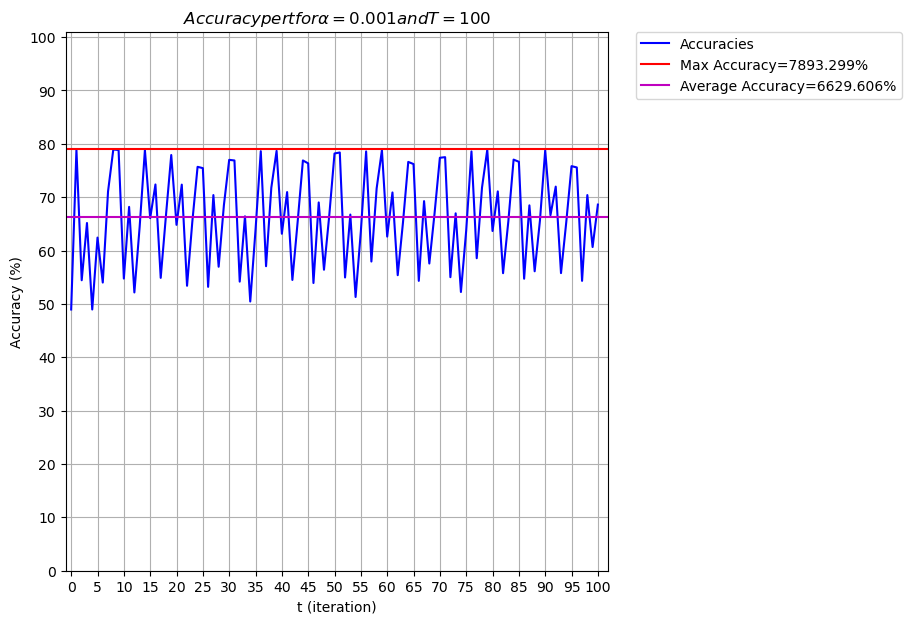

In [74]:
accuracies_per_weights_itr = accuracy_for_wlogs(Wlogs, x_train, y_train)
title = fr'$Accuracy per t for \alpha={a} and T={T}$'
graph_accuracies_per_t(accuracies_per_weights_itr, as_percentage=True, title=title)

In [75]:
np.vectorize(format_accuracy)(accuracies_per_weights_itr)

array(['4895.024%', '7888.985%', '5442.911%', '6515.674%', '4895.024%',
       '6242.450%', '5399.770%', '7106.701%', '7893.299%', '7883.233%',
       '5474.547%', '6817.659%', '5214.265%', '6440.897%', '7883.233%',
       '6606.270%', '7237.561%', '5487.489%', '6660.915%', '7789.761%',
       '6481.162%', '7234.685%', '5339.373%', '6537.245%', '7568.306%',
       '7543.860%', '5319.241%', '7039.114%', '5696.002%', '6852.171%',
       '7699.166%', '7687.662%', '5417.026%', '6640.782%', '5044.579%',
       '6383.376%', '7861.662%', '5706.068%', '7177.164%', '7867.414%',
       '6314.351%', '7095.197%', '5448.663%', '6538.683%', '7687.662%',
       '7633.017%', '5391.142%', '6901.064%', '5639.919%', '6655.162%',
       '7818.522%', '7837.216%', '5494.679%', '6673.857%', '5129.422%',
       '6361.806%', '7857.348%', '5793.788%', '7165.660%', '7880.357%',
       '6261.145%', '7088.007%', '5537.820%', '6527.179%', '7660.339%',
       '7620.075%', '5431.406%', '6925.510%', '5756.399%', '6702

#### Return cross entropy for all w iterations

In [76]:
def Cross_Entropy(w, x, y, threshold):
    CEsum = []
    for n in range(w.shape[0]):
        p = ProbabilisticLogRegClassifier(w[n], x)
        # Avoid log issues
        p[p == 0] = 1e-16
        p[p == 1] = 1 - 1e-16
        yn = FinalClassification(p, threshold)
        CEsum.append(-1*np.sum(y*np.log(p)+(1-y)*np.log(1-p)))
    return CEsum

#### Return confusion matrix

In [77]:
def ConfusionMat(Ypredicted, Y):
    conMat = np.zeros((2, 2))
    for n in range(Ypredicted.size):
        if Y[n] == 0:
            if Ypredicted[n] == 0:
                conMat[1, 1] += 1
            else:
                conMat[0, 1] += 1
        else:
            if Ypredicted[n] == 0:
                conMat[1, 0] += 1
            else:
                conMat[0, 0] += 1
    return conMat

#### Plot confusion matrix

In [78]:
def plotConfusionMatrix(cm):
    plt.figure(figsize=(6, 6))
    plt.title("Confusion Matrix")
    df_cm = pd.DataFrame(cm, index=["Predicted Positive", "Predicted Negative"], columns=["Actual Positive", "Actual Negative"])
    sn.heatmap(df_cm, annot=True, fmt=".0f", cbar=False)
    plt.show()

#### Build and plot the ROC

In [79]:
def ROC(P, Yactual):
    FPR = []
    TPR = []
    # Calculate false positive and true positive rates for different thresholds between 0 and 1
    for threshold in np.linspace(1, 0, 11):
        Ypredicted = FinalClassification(P, threshold)
        cm = ConfusionMat(Ypredicted, Yactual)
        FPR.append(cm[0][1] / (cm[0][1] + cm[1][1]))
        TPR.append(cm[0][0] / (cm[0][0] + cm[1][0]))
    # Plot ROC with the false and true positive rates we calculated
    plt.figure(figsize=(6, 6))
    plt.title('ROC')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.scatter(FPR, TPR, color='b')
    plt.plot(FPR, TPR, color='b')
    plt.grid()
    plt.show()

#### Plot accuracy over T iterations for train data

In [80]:
def plotAccTrain(X, Y):
    AccVec = AccuracyVector(wUpdated, X, Y)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy of classification for t times w update for train data')
    plt.xlabel("t values")
    plt.ylabel("Accuracy rate")
    plt.plot(t, AccVec, color='b')
    plt.grid()
    plt.show()

#### Plot accuracy over T iterations for test data

In [81]:
def plotAccTest(X, Y):
    AccVec = AccuracyVector(wUpdated, X, Y)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy of classification for t iterations of w update for test data')
    plt.xlabel("t values")
    plt.ylabel("Accuracy rate")
    plt.plot(t, AccVec, color='b')
    plt.grid()
    plt.show()

#### Plot cross entropy loss for train data

In [82]:
def plotCEtrain():
    crossEnt = Cross_Entropy(wUpdated, XtrainNormalized, Ytrain, threshold)
    t = range(1, wUpdated.shape[0]+1)
    plt.figure(figsize=(6, 6))
    plt.title('Cross entropy for train data')
    plt.xlabel("t values")
    plt.ylabel("Cross Entropy Loss")
    plt.plot(t, crossEnt, color='b')
    plt.grid()
    plt.show()